## NLP TASK - SUGGESTION PREDICTION
### KAUSTAV CHANDA  &nbsp;&nbsp;&nbsp;  https://github.com/Kaustav97 


---



### Key points of my approach for this task
 -   Given that training data was limited, I chose to extend a pre-built vocabulary : the 20,000 most common words in Wikipedia dictionary => common_vocab.pkl 
 -   Used GloVe vectors as the vectorizor to build the initial Embedding layer
 -   Trained a 5-layer network, with a Bidirectional GRU running on the embeddings, followed by a Unidirectional GRU on the concatenated outputs, with 3 dense layers to build up to the final prediction
 
 ### Input:
 -   common_vocab.pkl - stock dictionary of word tokens
 -   glove.6B.zip - downloaded by the script (takes few seconds on Colab)


In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip && unzip glove.6B.zip

--2019-03-26 15:50:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-03-26 15:50:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  11.7MB/s    in 63s     

2019-03-26 15:51:42 (13.0 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
## read training .csv file

import pandas as pd
df = pd.read_csv('V1.4_Training.csv',names=['idx','text','label','rem'])
df = df.drop(['idx','rem'],axis=1) 

#### Text Preprocessing

Series of operations applied in order:
> 1. Replace all links, and dotted addresses with <link\> token , so as to differentiate them from normal word 'link'
> 2. Remove all items in set {$%@&*#}
> 3. Remove parentheses
> 4. Remove series of dots, underscores and whitespaces
> 5. convert everything to lowercase

In [0]:
import re
repl= {'"':''}
df = df.replace(repl,regex=True)
# LINKS: 
df['text'] = df['text'].apply(lambda x:re.sub(r"(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])?" ,r" <LINK> ",x) )
df['text'] = df['text'].apply(lambda x:re.sub(r"\w+((\.\w+))+",r" <LINK> ",x) )
df['text'] = df['text'].apply(lambda x:re.sub(r"[$%@&*#]",r" ",x) )
df['text'] = df['text'].apply(lambda x:re.sub(r"[\(|\)]",r" ",x) )
# df['text'] = df['text'].apply(lambda x:re.sub(r"(\w)\.(\w)",r"\1 \2",x) )
df['text'] = df['text'].apply(lambda x:re.sub(r"(\.)(\.+)",r" ",x))
df['text'] = df['text'].apply(lambda x:re.sub(r"_+",r" ",x) )
df['text'] = df['text'].apply(lambda x:re.sub(r"\s+",r" ",x) )
df['text'] = df['text'].apply(lambda x:x.lower() )

In [4]:
tmp = df
pd.set_option('display.max_colwidth', -1)
print( df['text'].sample(100) )
# print(tmp.iloc[782])
# print(tmp.iloc[785])
# print(tmp.iloc[789])


255     windows phone <link> introduces the social extensibility framework.                                                                                                                                                                                                                                                                                                                                                                                                
4706    i'm delaying the registration and app creation, untill it is possible.                                                                                                                                                                                                                                                                                                                                                                                             
5801    so at the moment i have to tell my customers: open the folder-picker and

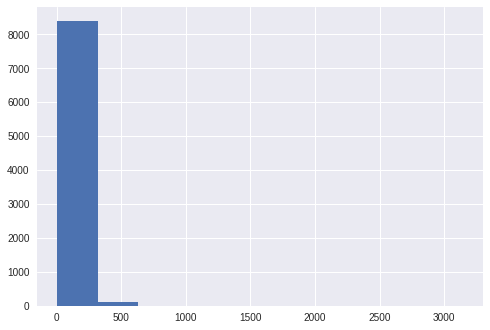

In [5]:
df['length'] = df['text'].apply(lambda x:len(x))
df['length'].hist()

Huge disparity in text lenghts! We remove negligible instances by keeping 500 as the cutoff threshold. Hence , keep maxlen=500 words

In [6]:
print("BEFORE",df.count())
df = df[df['length']<500]
print( "AFTER",df.count() )

BEFORE text      8500
label     8499
length    8500
dtype: int64
AFTER text      8480
label     8479
length    8480
dtype: int64


In [7]:
neg_df = df[df['label']=='0']
pos_df = df[df['label']=='1']
print(pos_df.count())
print(neg_df.count())
print(df.count())

text      2078
label     2078
length    2078
dtype: int64
text      6389
label     6389
length    6389
dtype: int64
text      8480
label     8479
length    8480
dtype: int64


In [10]:
# sample positive and negative datasets:
pos_df['text'].sample(30) , neg_df['text'].sample(30)

(7649    please provide the ability to the developer to change the color of the keyboard inside their app.                                                                                                                                                  
 6991    i think microsoft needs or boost xaml development or if it doesn't interest it open source it then the community can itself improve it                                                                                                             
 7797    also the scroll viewer should have options to disable overscrolling effect.                                                                                                                                                                        
 406     i would like to be able to tell the system to always open with skype.                                                                                                                                                                   

In [16]:
# Build GloVe index from file
import numpy as np
import pandas as pd
import re
import keras
import pickle
from keras.layers import Input, Dense, GRU, Dropout
from keras.models import Model
import numpy as np


def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map
  

words_to_index, index_to_words, word_to_vec_map = read_glove_vecs('glove.6B.300d.txt')

Using TensorFlow backend.


Input Text Preprocessing: 
-  let's -> let us, won't -> will not , etc

In [0]:
def clean_str(string):
    string = string.strip().lower()
    
    if 'let\'s' in string:
      string = re.sub(r'let\'s', 'let us', string)
    if 'lets' in string:
      string = re.sub(r'lets', 'let us', string)
      
    string = re.sub(r"\'s", " is", string)
    string = re.sub(r"\'ve", " have", string)
    if 'wont ' in string:
      string = re.sub(r"won\'?t", "will not", string)
    if 'won\'t ' in string:
      string = re.sub(r"won\'?t", "will not", string)
    if 'dont ' in string:
      string = re.sub(r"don\'?t", "do not", string)
    if 'don\'t ' in string:
      string = re.sub(r"don\'?t", "do not", string)
    
    if 'cant ' in string:
      string = re.sub(r"can\'?t", " can not", string)
    if 'can\'t ' in string:
      string = re.sub(r"can\'?t", " can not", string)

    string = re.sub(r"n\'t", " not", string)
    string = re.sub(r"\'re", " are", string)
    string = re.sub(r"\'d", " would", string)
    string = re.sub(r"\'ll", " will", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", "", string)
    
    return string.strip()

In [0]:
## BUILD INPUT TEXT LIST FROM DATAFRAME 
def load_data_and_labels(positive_df,negative_df):
    # Load data from files
    positive_examples = positive_df['text'].values
    positive_examples = [s.strip() for s in positive_examples]

    negative_examples = negative_df['text'].values
    negative_examples = [s.strip() for s in negative_examples]
    
    print (len(positive_examples), len(negative_examples))
    # Split by words
    x_text = positive_examples + negative_examples
    x_text = [clean_str(sent) for sent in x_text]
    # Generate labels
    positive_labels = [1 for _ in positive_examples]
    negative_labels = [ 0 for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return [x_text, y]

In [17]:
x_text, y = load_data_and_labels(pos_df,neg_df)

2078 6389


In [0]:
# CREATE LISTS FROM TEXT AND LABELS FOR TRAINING
df2 = pd.DataFrame()
df2['text'] = x_text
df2['label'] = y

np.random.seed(10)
df2 = df2.sample(frac = 1)
ls = list(df2.text)
y = df2.label

df2 = (df2[df2['text'] != ''])

y = list(y)

In [0]:
## EXTEND PRE BUILD VOCABULARY WITH ALL NEW WORDS IN OUR DATASET
dic = {}
with open('common_vocab.pkl', 'rb') as f:
    dic = pickle.load(f)
words = list(set(' '.join(ls).split()))
count = 20654
for i in words:
  if i not in dic.keys():
    dic[i] = count
    count+=1
    
ct1 = 0
maxlen = 500
arr = np.zeros((len(ls), maxlen))
for pos,sent in enumerate(ls):
  sent1 = sent.split()
  ct2 = 0
  for word in (sent1):
    arr[ct1, ct2] = dic[word]
    ct2+=1
  ct1+=1

In [21]:
## NEW, LARGER DICTIONARY
len(dic)

27577

In [0]:
## TRAIN, TEST, AND DEV ARRAYS : 9:1 SPLIT
vocab_size = len(dic) + 1
x_train = arr
y_train = y

In [23]:
from sklearn.utils import shuffle
import math
print(x_train.shape)
print(len(y_train))
print(len(ls))
length = math.floor(0.9*len(x_train))
x_train, y_train, ls = shuffle(x_train, y_train, ls, random_state=0)
x_test = x_train[length:]
x_train = x_train[:length]
y_test = y_train[length:]
y_train = y_train[:length]
ls_test = ls[length:]
ls_train = ls[:length]
print(x_train.shape)
print(x_test.shape)
print(len(y_train))
print(len(y_test))
print(len(ls_train))
print(len(ls_test))

(8467, 500)
8467
8467
(7620, 500)
(847, 500)
7620
847
7620
847


In [25]:
## CLASS WEIGHTING, DO TO IMBALANCE IN DATASET
a = np.zeros((len(y_train), 2))

count0, count1 = 0, 0
count0 += list(y_train).count(0)
count1 += list(y_train).count(1)
summ = sum([count0, count1])
class_weights = [1.0-float(count0)/float(summ), 1.0-float(count1)/float(summ)]
print ([i/sum(class_weights) for i in class_weights])

[0.24606299212598426, 0.7539370078740157]


In [0]:
# CREATE EMBED MATRIX FROM GLOVE VECTOR INDEXES
import numpy as np
vocab_size = len(dic) + 1
np.random.seed(10)
embed_matrix1 = np.zeros((vocab_size, 300))
for word,index in dic.items():
  try:
    embed_matrix1[index, :] = word_to_vec_map[word]
  except:
    embed_matrix1[index, :] = np.random.uniform(-1, 1, 300)

In [28]:
%%shell
mkdir runs/

In [30]:
np.array(x_train).shape

(7620, 500)

In [0]:
import os
import re
import tensorflow_hub as hub
import math
import os
import time
import tensorflow as tf
import tqdm
from keras.layers import Embedding,Bidirectional, Lambda, concatenate
from keras.callbacks import ModelCheckpoint

model_2 = None

embed_layer = Embedding(input_dim = vocab_size, output_dim = 300, embeddings_initializer = 'glorot_uniform', trainable = False)
embed_layer.build([None])
embed_layer.set_weights([embed_matrix1])

inp = Input(shape = (maxlen,))

embeddings = embed_layer(inp)

gru = Bidirectional(GRU(128,return_sequences=True) ,merge_mode='concat')(embeddings)

gru = GRU(128)(gru)
dense = Dense(128, activation = 'relu')(gru)
dropout = Dropout(0.8)(dense)

dense = Dense(64, activation = 'relu')(dense)
dropout = Dropout(0.8)(dense)

dense = Dense(1, activation = 'sigmoid')(dense)


model_2 = Model(inp, dense)
model_2.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0), metrics = ['accuracy'])

model_checkpoint = ModelCheckpoint("./runs/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=False,
                                  save_weights_only=False,
                                  mode='auto',
                                  period=1)

model_2.fit(x_train,y_train,epochs=500,shuffle=True,validation_data=[x_test,y_test],callbacks=[model_checkpoint],batch_size=64,class_weight={0.24704646888947235, 0.7529535311105278} )


#### Download saved model weights from Drive:
https://drive.google.com/open?id=1HpZ2_W7vIMRwTiRvocYdvRd3yYMtZXzj

save all .hdf5 model files to /runs directory

In [0]:
#############################################################
# RUN MODEL ON NEW DATA
#############################################################

#### Independent section, meant for testing saved models on new data files
Inputs:
-  all .hdf5 files in /runs directory
-  Test_File.csv 
-  True_File.csv

In [0]:
def preprocess(x):  
  x= re.sub(r"(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])?" ,r" <LINK> ",x)
  x= re.sub(r"\w+((\.\w+))+",r" <LINK> ",x) 
  x= re.sub(r"[$%@&*#\"\"]",r" ",x)
  x= re.sub(r"[\(|\)]",r" ",x) 
  x= re.sub(r"(\.)(\.+)",r" ",x)
  x= re.sub(r"_+",r" ",x) 
  x= re.sub(r"\s+",r" ",x) 
  x= x.lower()
  x= clean_str(x)
  return x


 Evaluation run on  Test_File.csv file

In [0]:
trial = pd.read_csv('SubtaskA_EvaluationData.csv',header=None)

In [39]:
qry = list(trial.iloc[:,1])
qry = [preprocess(x) for x in qry]
for x in qry[:20]:
  print(x)

this would enable live traffic aware apps.
please try other formatting like bold italics shadow to distinguish titles/subtitles from content.
since computers were invented to save time i suggest we be allowed to upload them all in one zip file - using numbering for the file names and the portal could place them in the right order.
allow rearranging if the user wants to change them
add simd instructions for better use of arm neon instructions for math and games.
also using a hot swapping code generator optimized machine code like hotspot in java does would also be very helpful to mitigate slow c code.
microsoft should seriously look into getting rid of symantec for all these payment stuff.
i would be extremely useful in a variety of app types to be notified upon call started and ended events at least be able to check whether or not the device is being used for a phonecall.
i would like to see informatin about the certification process in the dev center app.
it would be nice to see at a 

Sample run of a model on Test_File.csv

In [0]:
from keras.models import load_model
model_tst = load_model('/content/runs/weights.15-0.88.hdf5')

In [41]:
import numpy as np
maxlen = 500

dic = {}
with open('common_vocab.pkl', 'rb') as f:
    dic = pickle.load(f)
words = list(set(' '.join(qry).split()))
count = 20654
for i in words:
  if i not in dic.keys():
    dic[i] = count
    count+=1
    
vocab_size = len(dic) + 1
np.random.seed(10)
embed_matrix1 = np.zeros((vocab_size, 300))
for word,index in dic.items():
  try:
    embed_matrix1[index, :] = word_to_vec_map[word]
  except:
    embed_matrix1[index, :] = np.random.uniform(-1, 1, 300)    
    
tst = np.zeros((len(qry),maxlen))
ct2=0
for sen in qry:  
  ct1=0
  for word in sen.split():
    try:
      tst[ct2,ct1] = dic[word]
    except:
      tst[ct2,ct1]=dic['<UNK>']
    ct1+=1
  ct2+=1
print(tst.shape)

preds = model_tst.predict(tst)


(833, 500)


In [0]:
preds = model_tst.predict(tst)
preds = [int(round(x)) for x in preds.flatten()]
trial[2] = preds
trial.to_csv('submission.csv')

In [0]:
# SAMPLE MODEL OUTPUT
for i,conf in enumerate(preds[:20]):
  print("{} : {}".format(conf,qry[i]))

[0.00977653] : i'm not asking microsoft to gives permission like android so any app can take my data ,  but do not keep it restricted like iphone.
[0.00014952] : somewhere between android and iphone.
[0.00014481] : and in the windows store you can flag the app [requires trust] for example.
[9.62615e-06] : many thanks sameh hi ,  as we know ,  there is a lot of limitations is wp8 os due the high security in the os itself which is very good ,  but some time we need to allow some apps to do extra works ,  apps which we trust <link> : hotmail app ,  facebook app ,  skype app
[0.00028023] : the idea is that we can develop a regular app and we request our permissions in the manifest ,  or the app can ask for trust � more
[0.99997413] : please add this simple and extremely helpful feature.
[0.00893515] : why not let us have several pages that we can put tiles on and name whatever we want to .
[0.08051771] : the idea is if user running our app and by any reason he rebooted the phone so in that

##### Evaluate all models on SubtaskA_Trial_Test.csv

In [0]:
from sklearn.metrics import f1_score

y_true = pd.read_csv('True_File.csv',header=None).iloc[:,2]

for mod in os.listdir('runs'):  
  model_tst = load_model(os.path.join('/content','runs',mod))
  preds = model_tst.predict(tst) 
  y_pred =[int(round(x)) for x in preds.flatten()] 
  print("{} -> {} ".format(mod,f1_score(y_true,y_pred)) )

weights.15-0.88.hdf5 -> 0.7572463768115941 
weights.14-0.49.hdf5 -> 0.7137254901960786 
weights.06-0.37.hdf5 -> 0.7874564459930314 
weights.23-0.62.hdf5 -> 0.7228464419475654 
weights.10-0.50.hdf5 -> 0.7678244972577698 
weights.17-0.85.hdf5 -> 0.7374301675977653 
weights.19-0.72.hdf5 -> 0.75 
weights.01-0.42.hdf5 -> 0.332425068119891 
weights.05-0.32.hdf5 -> 0.790035587188612 
weights.12-0.55.hdf5 -> 0.739622641509434 
weights.11-0.56.hdf5 -> 0.7364485981308412 
weights.16-0.64.hdf5 -> 0.7411545623836128 
weights.21-0.62.hdf5 -> 0.7283236994219653 
weights.18-0.71.hdf5 -> 0.7622504537205081 
weights.08-0.54.hdf5 -> 0.6626016260162602 
weights.20-0.79.hdf5 -> 0.7382297551789078 
weights.02-0.36.hdf5 -> 0.5060240963855421 
weights.09-0.62.hdf5 -> 0.7838312829525483 
weights.03-0.37.hdf5 -> 0.4568527918781726 
weights.22-0.64.hdf5 -> 0.7037773359840954 
weights.13-0.54.hdf5 -> 0.7286245353159851 
weights.07-0.31.hdf5 -> 0.7518796992481203 
weights.04-0.25.hdf5 -> 0.769230769230769 


In [0]:
########################################
## UTILITY FUNCTIONS
########################################

In [32]:
pip install pydrive

    100% |████████████████████████████████| 993kB 20.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile(
    {'q': "'1HpZ2_W7vIMRwTiRvocYdvRd3yYMtZXzj' in parents"}).GetList()
dicti = {}
for f in file_list:
  try:
    dicti[f['title']] = f['id']
    fname = os.path.join("runs", f['title'][-20:])
    print('downloading {} to {}'.format(f['title'],fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)
    
  except:
    continue

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

for i in os.listdir('./runs'):
  fid = '1HpZ2_W7vIMRwTiRvocYdvRd3yYMtZXzj'
  f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": fid}]})
  f.SetContentFile('./runs/'+i)
  f.Upload()
  print(i)